# <center>Dubai Metro Station Categorization</center>
### <center>Categorization is based on 6 categories namely Food & Drink Shops, School, Medical Center, Fitness Center, Restaurants and Shopping Mall</center>

In [126]:
import requests
import folium 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

In [127]:
#!conda install -c conda-forge folium=0.5.0 --yes

In [128]:
# The code was removed by Watson Studio for sharing.

### Get latitude\longitude of all metro stations of Dubai from Foursquare

In [129]:

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitudes, 
            longitudes, 
            category,
            radius, 
            LIMIT)
results = requests.get(url).json()

### Give Dataframe column names meaningful

In [131]:
#results
dataframe = json_normalize(results['response']['venues'])
dataframe.head()
dataframe.columns=['Categories','hasPark','Id','Address','CountryCode','City','Country','Street','Distance','FormateAddress','Lat/Lon','Latitude','Longitude','Neighborhood','State','Name','ReferralId']
dataframe.head()

,Categories,hasPark,Id,Address,CountryCode,City,Country,Street,Distance,FormateAddress,Lat/Lon,Latitude,Longitude,Neighborhood,State,Name,ReferralId
0,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",False,4b9511eaf964a520ec8d34e3,Red Line (25),AE,دبي,الإمارات العربية المتحدة,Sheikh Zayed Rd,402,"[Red Line (25) (Sheikh Zayed Rd), دبي, الإمارا...","[{'label': 'display', 'lat': 25.20138350079839...",25.201384,55.269504,NaN,دبي,Burj Khalifa / Dubai Mall Metro Station (محطة ...,v-1570982863
1,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",False,4bdafe1fc79cc9284b8d80e9,Red Line (21),AE,دبي,الإمارات العربية المتحدة,Sheikh Khalifa Bin Zayed St,3816,"[Red Line (21) (Sheikh Khalifa Bin Zayed St), ...","[{'label': 'display', 'lat': 25.23323696869449...",25.233237,55.291975,NaN,دبي,Al Jafiliya Metro Station (محطة الجافلية),v-1570982863
2,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",False,4b7d0e48f964a52054ad2fe3,Sheikh Zayed Rd,AE,دبي,الإمارات العربية المتحدة,NaN,856,"[Sheikh Zayed Rd, دبي, الإمارات العربية المتحدة]","[{'label': 'display', 'lat': 25.21115763344785...",25.211158,55.275584,NaN,دبي,Financial Centre Metro Station (محطة مترو المر...,v-1570982863
3,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",False,5b796b99a0215b002c0d83b9,NaN,AE,دبي,الإمارات العربية المتحدة,NaN,19948,"[دبي, الإمارات العربية المتحدة]","[{'label': 'display', 'lat': 25.07105759855298...",25.071058,55.139046,NaN,دبي,DMCC Metro Station,v-1570982863
4,"[{'id': '4bf58dd8d48988d1fd931735', 'name': 'M...",False,5b571b64c03635002c550e05,NaN,AE,دبي,الإمارات العربية المتحدة,NaN,5196,"[دبي, الإمارات العربية المتحدة]","[{'label': 'display', 'lat': 25.244407, 'lng':...",25.244407,55.298112,NaN,دبي,Adcb Metro Station,v-1570982863


### Remove unwanted columns

In [132]:
columns = ['Id','hasPark','Address','CountryCode','City','Country','Distance','FormateAddress','Lat/Lon','Neighborhood','State','ReferralId']
dataframe.drop(columns, inplace=True, axis=1)


In [133]:
dataframe.shape

(50, 5)

### Delete duplicate metro stations

In [134]:
# ADCb Metro station and Ittihad Metro Station is coming twice so delete one of them
indexNames = dataframe[ dataframe['Name'] == 'Adcb Metro Station' ].index
dataframe.drop(indexNames , inplace=True)

indexNames = dataframe[ dataframe['Name'] == 'Ittihad Metro Station' ].index
dataframe.drop(indexNames , inplace=True)

dataframe.shape

(48, 5)

### Display all metro station on Dubai Map

In [135]:
# create map of Manhattan using latitude and longitude values
map_dubai = folium.Map(width=1500,height=1000,location=[latitudes, longitudes], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dubai)  
    
map_dubai

### Function to get venues for each metro station

In [136]:
def getCategorybyVenues(names, latitudes, longitudes, radius=500):
    category_dict = {"Food and Drinks":"4bf58dd8d48988d1f9941735","Schools":"4bf58dd8d48988d13b941735","Medical Center":"4bf58dd8d48988d104941735","Fitness Center":"4bf58dd8d48988d175941735","Restaurants":"4d4b7105d754a06374d81259","Shopping Mall":"4bf58dd8d48988d1fd941735"}
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        for c in category_dict:
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                category_dict[c],
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['venues']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                #v['categories'][0]['name']) for v in results])
                c) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [137]:
metro_venues = getCategorybyVenues(names=dataframe['Name'],
                                   latitudes=dataframe['Latitude'],
                                   longitudes=dataframe['Longitude']
                                  )

Burj Khalifa / Dubai Mall Metro Station (محطة برج خليفة / دبي مول)
Al Jafiliya Metro Station (محطة الجافلية)
Financial Centre Metro Station (محطة مترو المركز المالي)
DMCC Metro Station
Business Bay Metro Station (محطة الخليج التجاري)
Al Raha St
Baniyas Square Metro Station محطة مترو بني ياس (محطة بني ياس)
Creek Metro Station (محطة الخور)
Emirates Towers Metro Station (محطة أبراج الإمارات)
Al Fahidi Metro Station (محطة الفهيدي)
Dubai Marina Platform - Dubai Metro
Rashidiya Metro Station (الراشدية)
Al Jadaf Metro Station (محطة مترو الجداف)
Emirates Metro Station (محطة مترو طيران الإمارات)
Oud Metha Metro Station (محطة عود ميثاء)
Al Rigga Metro Station (محطة الرقة)
Burjuman Metro Station (محطة برجمان)
Deira City Centre Metro Station (محطة ديرة سيتي سنتر)
World Trade Centre Metro Station (محطة المركز التجاري العالمي)
Mall of the Emirates Metro Station (محطة مترو مول الإمارات)
Ibn Battuta Metro Station (محطة ابن بطوطة)
Union Metro Station محطة مترو الاتحاد (محطة الاتحاد)
Terminal 3 Metro St

In [138]:
metro_venues.head()
metro_venues.drop(['Venue','Venue Latitude','Venue Longitude'],axis=1,inplace=True)

### Function to filter data for each category and create Bar plot

In [140]:
def PlotMetroByVenues(category,color):
    df_venues = metro_venues[metro_venues['Venue Category'] == category]
    df_venues_tran = df_venues.groupby(['Neighborhood'],as_index=False).count() 
    df_venues_tran.set_index(df_venues_tran.columns[0],inplace=True)
    df_venues_tran.sort_values(by='Venue Category',ascending=False,inplace=True)
    df_venues_tran['Venue Category'].plot(kind='bar',color=color, figsize=(20, 5))
    plt.title('Bar Chart of ' + category + ' Venues') # add a title to the histogram
    plt.ylabel('Number of Venues') # add y-label
    plt.xlabel('Metro Stations') # add x-label
    plt.show()
    print(df_venues_tran.head(5))    

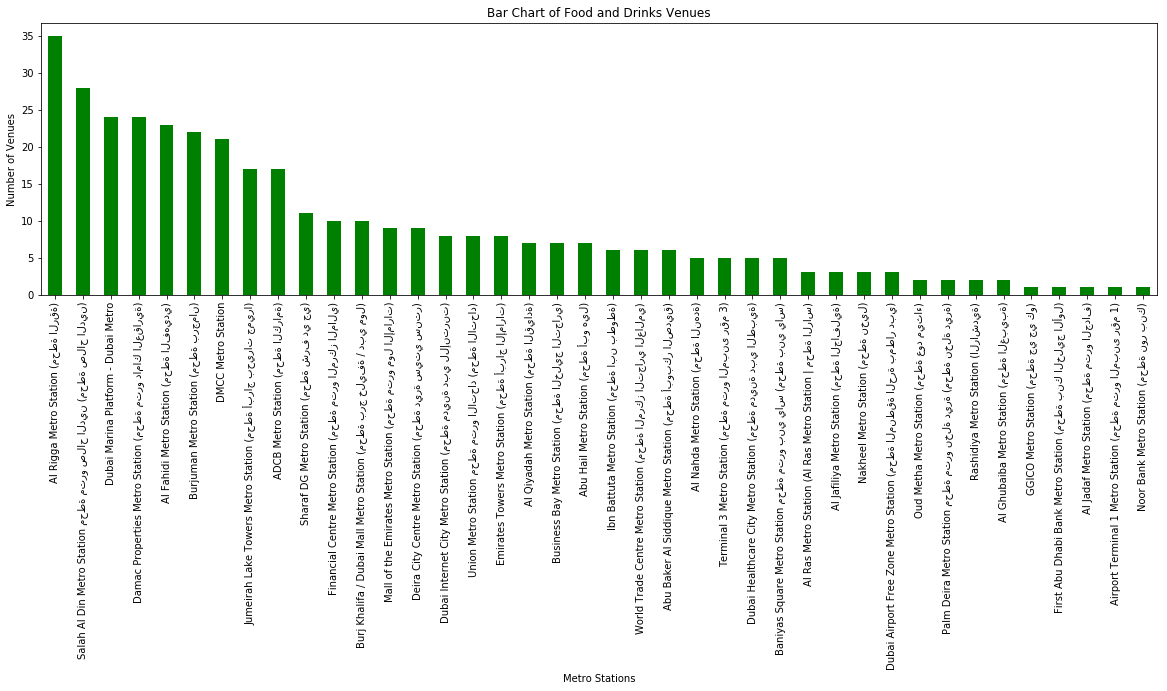

                                                    Neighborhood Latitude  \
Neighborhood                                                                
Al Rigga Metro Station (محطة الرقة)                                    35   
Salah Al Din Metro Station محطة مترو صلاح الدين...                     28   
Dubai Marina Platform - Dubai Metro                                    24   
Damac Properties Metro Station (محطة مترو داماك...                     24   
Al Fahidi Metro Station (محطة الفهيدي)                                 23   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Al Rigga Metro Station (محطة الرقة)                                     35   
Salah Al Din Metro Station محطة مترو صلاح الدين...                      28   
Dubai Marina Platform - Dubai Metro                                     24   
Damac Properties Metro Station (محطة مترو داماك...                    

In [141]:
PlotMetroByVenues('Food and Drinks','green')

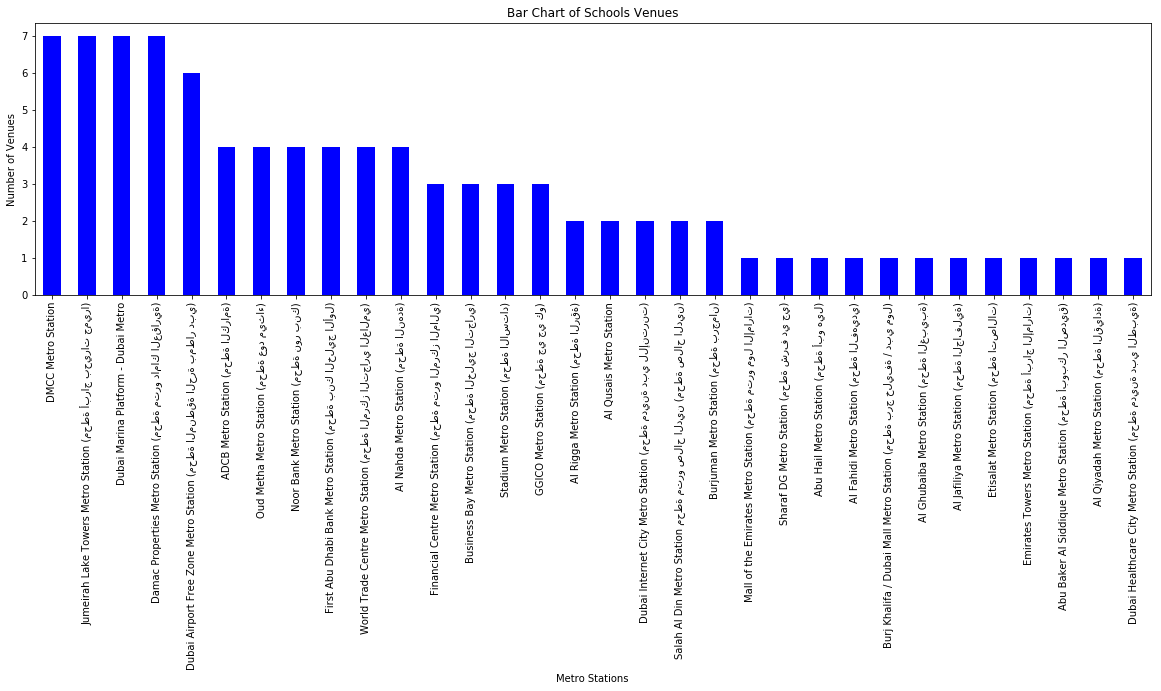

                                                    Neighborhood Latitude  \
Neighborhood                                                                
DMCC Metro Station                                                      7   
Jumeirah Lake Towers Metro Station (محطة أبراج ...                      7   
Dubai Marina Platform - Dubai Metro                                     7   
Damac Properties Metro Station (محطة مترو داماك...                      7   
Dubai Airport Free Zone Metro Station (محطة الم...                      6   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
DMCC Metro Station                                                       7   
Jumeirah Lake Towers Metro Station (محطة أبراج ...                       7   
Dubai Marina Platform - Dubai Metro                                      7   
Damac Properties Metro Station (محطة مترو داماك...                    

In [142]:
PlotMetroByVenues('Schools','blue')

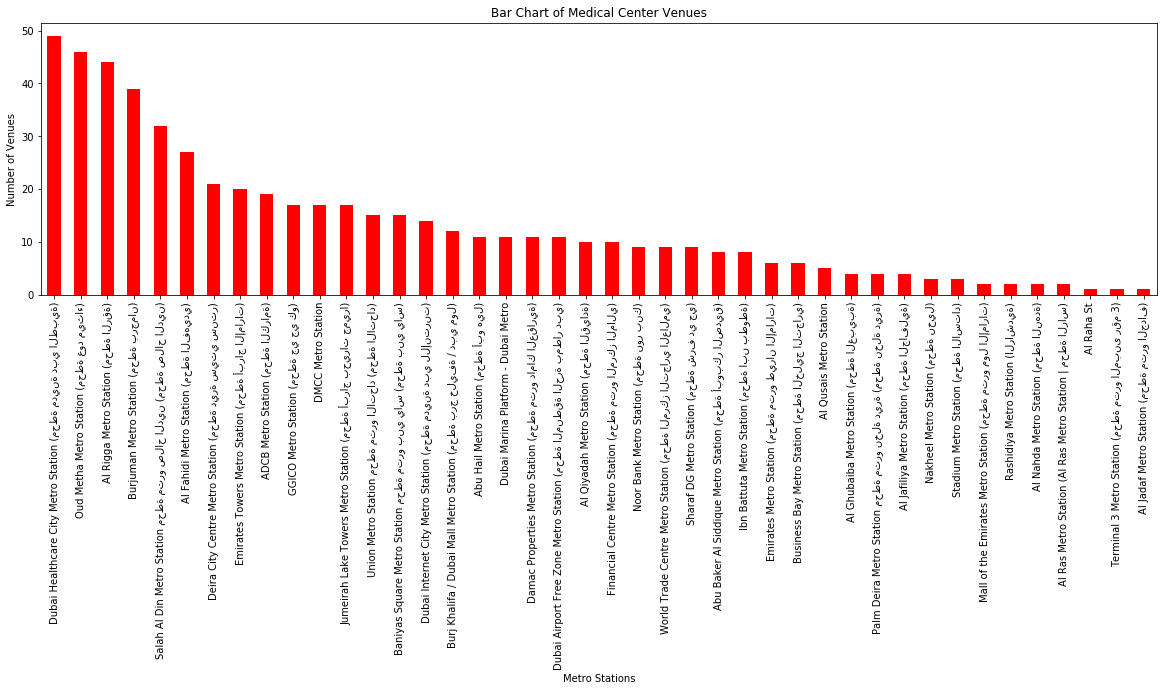

                                                    Neighborhood Latitude  \
Neighborhood                                                                
Dubai Healthcare City Metro Station (محطة مدينة...                     49   
Oud Metha Metro Station (محطة عود ميثاء)                               46   
Al Rigga Metro Station (محطة الرقة)                                    44   
Burjuman Metro Station (محطة برجمان)                                   39   
Salah Al Din Metro Station محطة مترو صلاح الدين...                     32   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Dubai Healthcare City Metro Station (محطة مدينة...                      49   
Oud Metha Metro Station (محطة عود ميثاء)                                46   
Al Rigga Metro Station (محطة الرقة)                                     44   
Burjuman Metro Station (محطة برجمان)                                  

In [143]:
PlotMetroByVenues('Medical Center','red')

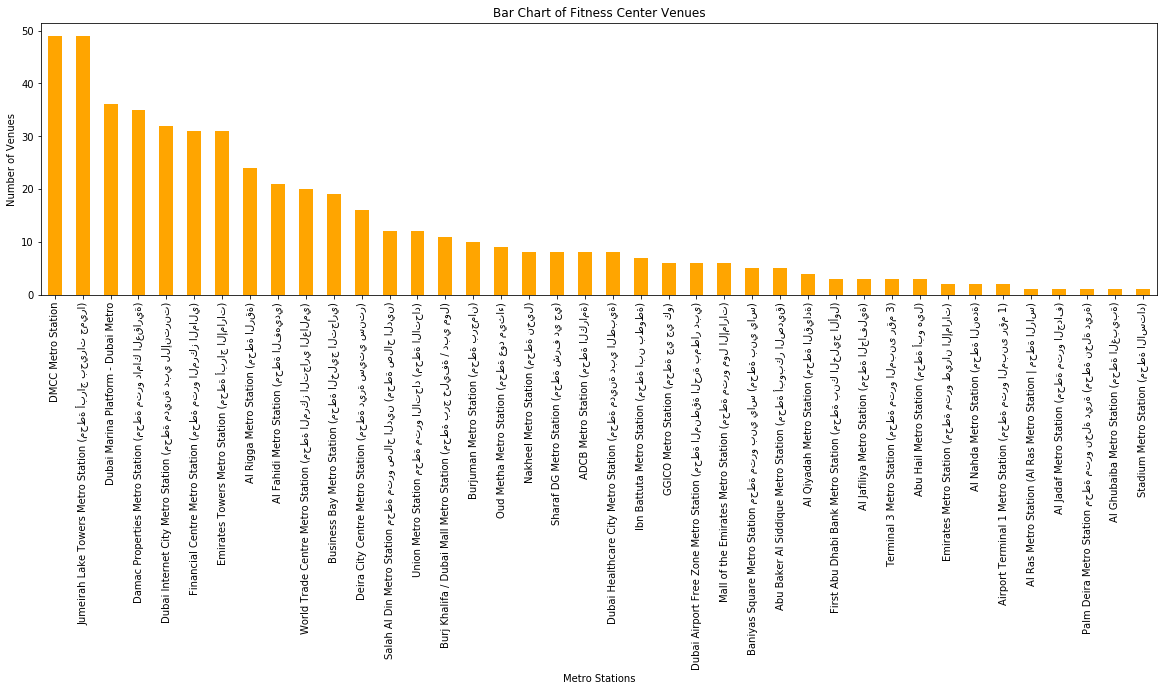

                                                    Neighborhood Latitude  \
Neighborhood                                                                
DMCC Metro Station                                                     49   
Jumeirah Lake Towers Metro Station (محطة أبراج ...                     49   
Dubai Marina Platform - Dubai Metro                                    36   
Damac Properties Metro Station (محطة مترو داماك...                     35   
Dubai Internet City Metro Station (محطة مدينة د...                     32   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
DMCC Metro Station                                                      49   
Jumeirah Lake Towers Metro Station (محطة أبراج ...                      49   
Dubai Marina Platform - Dubai Metro                                     36   
Damac Properties Metro Station (محطة مترو داماك...                    

In [144]:
PlotMetroByVenues('Fitness Center','orange')

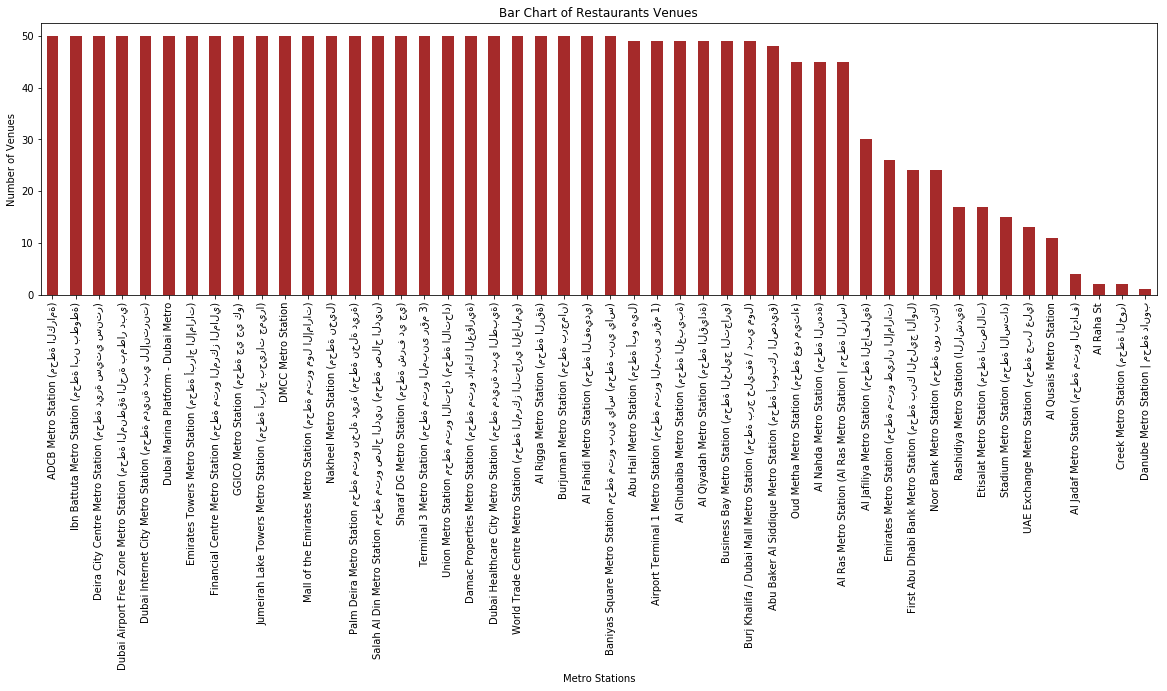

                                                    Neighborhood Latitude  \
Neighborhood                                                                
ADCB Metro Station (محطة الكرامة)                                      50   
Ibn Battuta Metro Station (محطة ابن بطوطة)                             50   
Deira City Centre Metro Station (محطة ديرة سيتي...                     50   
Dubai Airport Free Zone Metro Station (محطة الم...                     50   
Dubai Internet City Metro Station (محطة مدينة د...                     50   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
ADCB Metro Station (محطة الكرامة)                                       50   
Ibn Battuta Metro Station (محطة ابن بطوطة)                              50   
Deira City Centre Metro Station (محطة ديرة سيتي...                      50   
Dubai Airport Free Zone Metro Station (محطة الم...                    

In [145]:
PlotMetroByVenues('Restaurants','brown')

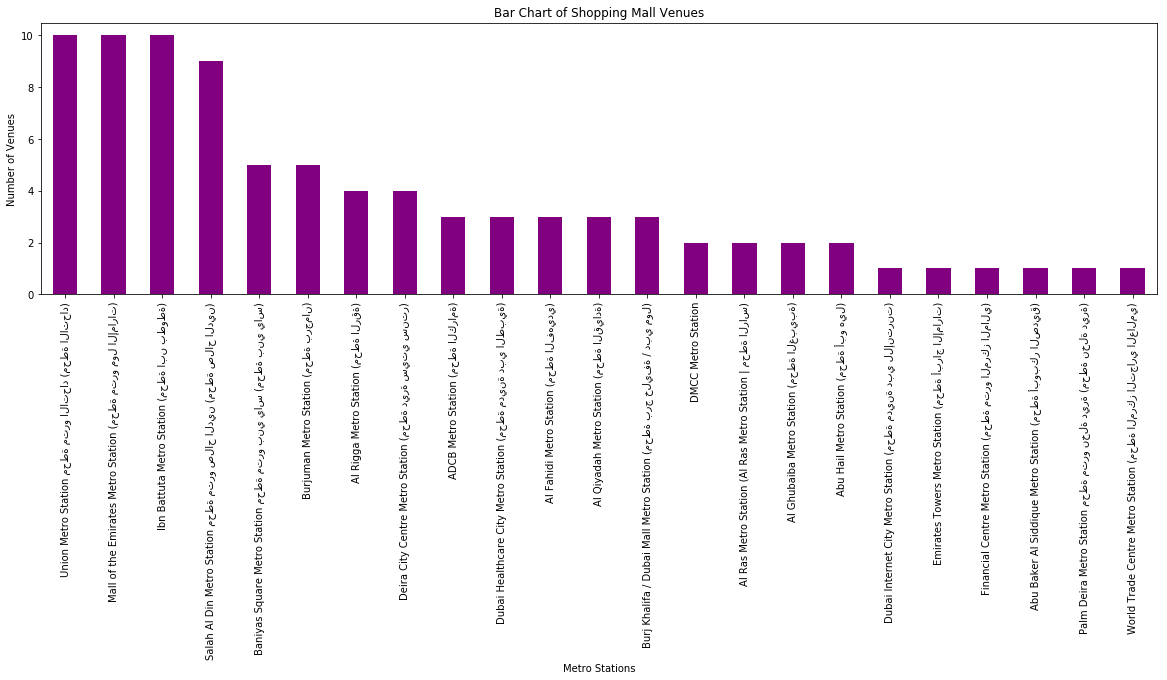

                                                    Neighborhood Latitude  \
Neighborhood                                                                
Union Metro Station محطة مترو الاتحاد (محطة الا...                     10   
Mall of the Emirates Metro Station (محطة مترو م...                     10   
Ibn Battuta Metro Station (محطة ابن بطوطة)                             10   
Salah Al Din Metro Station محطة مترو صلاح الدين...                      9   
Baniyas Square Metro Station محطة مترو بني ياس ...                      5   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Union Metro Station محطة مترو الاتحاد (محطة الا...                      10   
Mall of the Emirates Metro Station (محطة مترو م...                      10   
Ibn Battuta Metro Station (محطة ابن بطوطة)                              10   
Salah Al Din Metro Station محطة مترو صلاح الدين...                    

In [146]:
PlotMetroByVenues('Shopping Mall','purple')

### Create Dataframe with features as columns

In [147]:
metro_venues_cat = metro_venues.groupby(['Neighborhood','Venue Category'],as_index=False).count() 

columns=["Metro Station","Latitude","Longitude","Food and Drinks","Schools","Medical Center","Fitness Center","Restaurants","Shopping Mall"]
metro_cat_df = pd.DataFrame(columns = columns)


In [148]:
metro = []


for row in metro_venues_cat.Neighborhood.unique():
    d1 = metro_venues[metro_venues['Neighborhood'] == row]
    lat = d1.iloc[0,1]
    long = d1.iloc[0,2]
    metro_cat_v1 = metro_venues_cat[metro_venues_cat['Venue Category']=='Food and Drinks'][metro_venues_cat['Neighborhood']==row]
    metro_cat_v2 = metro_venues_cat[metro_venues_cat['Venue Category']=='Schools'][metro_venues_cat['Neighborhood']==row]
    metro_cat_v3 = metro_venues_cat[metro_venues_cat['Venue Category']=='Medical Center'][metro_venues_cat['Neighborhood']==row]
    metro_cat_v4 = metro_venues_cat[metro_venues_cat['Venue Category']=='Fitness Center'][metro_venues_cat['Neighborhood']==row]
    metro_cat_v5 = metro_venues_cat[metro_venues_cat['Venue Category']=='Restaurants'][metro_venues_cat['Neighborhood']==row]
    metro_cat_v6 = metro_venues_cat[metro_venues_cat['Venue Category']=='Shopping Mall'][metro_venues_cat['Neighborhood']==row]
    
    try:
      metro_cat_v1_val = metro_cat_v1['Neighborhood Latitude'].iloc[0]
    except:
      metro_cat_v1_val =  0
    try:
      metro_cat_v2_val = metro_cat_v2['Neighborhood Latitude'].iloc[0]
    except:
      metro_cat_v2_val =  0
    try:
      metro_cat_v3_val = metro_cat_v3['Neighborhood Latitude'].iloc[0]
    except:
      metro_cat_v3_val =  0
    try:
      metro_cat_v4_val = metro_cat_v4['Neighborhood Latitude'].iloc[0]
    except:
      metro_cat_v4_val = 0
    try:
      metro_cat_v5_val = metro_cat_v5['Neighborhood Latitude'].iloc[0]
    except:
      metro_cat_v5_val =  0
    try:
      metro_cat_v6_val = metro_cat_v6['Neighborhood Latitude'].iloc[0]
    except:
      metro_cat_v6_val =  0
    metro.append([row,lat,long,metro_cat_v1_val,metro_cat_v2_val,metro_cat_v3_val,metro_cat_v4_val,metro_cat_v5_val,metro_cat_v6_val])
    #metro.append([row,metro_cat_v1_val,metro_cat_v2_val,metro_cat_v3_val,metro_cat_v4_val,metro_cat_v5_val,metro_cat_v6_val])
    dfMetro = pd.DataFrame(metro, columns = columns)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [149]:
dfMetro.set_index(dfMetro.columns[0],inplace=True)
dfMetro.head()

,Latitude,Longitude,Food and Drinks,Schools,Medical Center,Fitness Center,Restaurants,Shopping Mall
Metro Station,,,,,,,,
ADCB Metro Station (محطة الكرامة),25.244514,55.298161,17,4,19,8,50,3
Abu Baker Al Siddique Metro Station (محطة أبوبكر الصديق),25.270957,55.332781,6,1,8,5,48,1
Abu Hail Metro Station (محطة أبو هيل),25.275329,55.346341,7,1,11,3,49,2
Airport Terminal 1 Metro Station (محطة مترو المبنى رقم 1),25.248523,55.352390,1,0,0,2,49,0
Al Fahidi Metro Station (محطة الفهيدي),25.255787,55.295596,23,1,27,21,50,3


### Categorize Metro stations using K-means algorithm

In [150]:
# set number of clusters
kclusters = 3

#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfMetro)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 


array([0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 2, 1, 1, 2,
       1, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0, 1, 0, 0, 2, 1, 0, 2, 1, 0, 2,
       0, 2, 0, 0], dtype=int32)

In [151]:
# add clustering labels
dfMetro.insert(0, 'Cluster Labels', kmeans.labels_)
dfMetro.head()


,Cluster Labels,Latitude,Longitude,Food and Drinks,Schools,Medical Center,Fitness Center,Restaurants,Shopping Mall
Metro Station,,,,,,,,,
ADCB Metro Station (محطة الكرامة),0,25.244514,55.298161,17,4,19,8,50,3
Abu Baker Al Siddique Metro Station (محطة أبوبكر الصديق),0,25.270957,55.332781,6,1,8,5,48,1
Abu Hail Metro Station (محطة أبو هيل),0,25.275329,55.346341,7,1,11,3,49,2
Airport Terminal 1 Metro Station (محطة مترو المبنى رقم 1),0,25.248523,55.352390,1,0,0,2,49,0
Al Fahidi Metro Station (محطة الفهيدي),1,25.255787,55.295596,23,1,27,21,50,3


In [152]:
# Rename cluster lables to 'red', 'green' and 'blue'
dfMetro['Cluster Labels'].replace([0, 1, 2], ['red', 'blue', 'green'],inplace=True)

### Display Metro stations on Dubai Map with categorization colors 

In [153]:
# create map
map_clusters = folium.Map(location=[latitudes, longitudes], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
#clustercol = 5
for lat, lon, poi, cluster in zip(dfMetro['Latitude'], dfMetro['Longitude'], dfMetro.index, dfMetro['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster,#dfMetro['Cluster Labels'],#rainbow[clustercol-1],
        fill=True,
        fill_color=cluster,#dfMetro['Cluster Labels'],#rainbow[clustercol-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters



### Get mean of all features for each category

In [154]:
dfMetro.groupby('Cluster Labels').mean()

,Latitude,Longitude,Food and Drinks,Schools,Medical Center,Fitness Center,Restaurants,Shopping Mall
Cluster Labels,,,,,,,,
blue,25.186181,55.251099,16.857143,3.285714,25.571429,25.928571,49.642857,2.357143
green,25.125402,55.232949,0.615385,1.153846,2.384615,0.769231,14.307692,0.000000
red,25.224215,55.291678,5.904762,1.476190,8.000000,6.571429,49.142857,2.523810


<b>About Author:</b>

<b>Imtiyaz Alamshah- IT Project Manager</b> (Data Enthusiast)